In [1]:
## Load needed packages
import numpy as np 
import pandas as pd
import os
import shutil
from os import path
from sklearn import model_selection
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Convolution2D, Flatten, Dense, Dropout, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras import layers
from PIL import Image
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import TensorBoard
import codecs
import json
from sklearn import model_selection

In [2]:
# Read in data file and generate DF 
y_train_test = './data/256_images/iwildcam-2020-fgvc7/train2020.json'
y_train_test = './data/256_images/iwildcam2020_train_annotations.json'

with open(y_train_test) as file:
        y_train_test_annotations = json.load(file)
     
# Load categoreis    
categories_df = pd.DataFrame(y_train_test_annotations["annotations"])[["image_id","category_id"]]

# Load image file names
images_df = pd.DataFrame(y_train_test_annotations["images"])[["id", "file_name"]].rename(columns={"id":"image_id"})

# Merge category and image data
y_train_test_images_categories = pd.merge(categories_df, images_df, on="image_id")

# Convert categories to string
y_train_test_images_categories["category_id"]=y_train_test_images_categories["category_id"].astype(str)

# For testing
print("Training data: ")
y_train_test_images_categories

Training data: 


,image_id,category_id,file_name
0,96b00332-21bc-11ea-a13a-137349068a90,73,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,879d74d8-21bc-11ea-a13a-137349068a90,4,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,9017f7aa-21bc-11ea-a13a-137349068a90,227,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,90d93c58-21bc-11ea-a13a-137349068a90,250,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,887cd0ec-21bc-11ea-a13a-137349068a90,2,887cd0ec-21bc-11ea-a13a-137349068a90.jpg
...,...,...,...
217954,8b7899a2-21bc-11ea-a13a-137349068a90,372,8b7899a2-21bc-11ea-a13a-137349068a90.jpg
217955,958f609c-21bc-11ea-a13a-137349068a90,372,958f609c-21bc-11ea-a13a-137349068a90.jpg
217956,93bd2ede-21bc-11ea-a13a-137349068a90,372,93bd2ede-21bc-11ea-a13a-137349068a90.jpg
217957,8971956e-21bc-11ea-a13a-137349068a90,372,8971956e-21bc-11ea-a13a-137349068a90.jpg


In [3]:
# Lets see distribution between categories
pd.set_option('display.max_rows', None)
print("Frequency distribution in training data: ")

freq_table = pd.crosstab(index=y_train_test_images_categories["category_id"], columns="count")
freq_table = freq_table.sort_values("count")
freq_table

Frequency distribution in training data: 


col_0,count
category_id,
349,1
296,1
420,1
250,1
251,1
417,1
252,1
408,1
306,1


In [4]:
# Add image present or not column
pd.set_option('display.max_rows', 200)
y_train_test_images_categories["image_present"] = np.where(y_train_test_images_categories["category_id"]== "0", "0", "1")
y_train_test_images_categories

,image_id,category_id,file_name,image_present
0,96b00332-21bc-11ea-a13a-137349068a90,73,96b00332-21bc-11ea-a13a-137349068a90.jpg,1
1,879d74d8-21bc-11ea-a13a-137349068a90,4,879d74d8-21bc-11ea-a13a-137349068a90.jpg,1
2,9017f7aa-21bc-11ea-a13a-137349068a90,227,9017f7aa-21bc-11ea-a13a-137349068a90.jpg,1
3,90d93c58-21bc-11ea-a13a-137349068a90,250,90d93c58-21bc-11ea-a13a-137349068a90.jpg,1
4,887cd0ec-21bc-11ea-a13a-137349068a90,2,887cd0ec-21bc-11ea-a13a-137349068a90.jpg,1
...,...,...,...,...
217954,8b7899a2-21bc-11ea-a13a-137349068a90,372,8b7899a2-21bc-11ea-a13a-137349068a90.jpg,1
217955,958f609c-21bc-11ea-a13a-137349068a90,372,958f609c-21bc-11ea-a13a-137349068a90.jpg,1
217956,93bd2ede-21bc-11ea-a13a-137349068a90,372,93bd2ede-21bc-11ea-a13a-137349068a90.jpg,1
217957,8971956e-21bc-11ea-a13a-137349068a90,372,8971956e-21bc-11ea-a13a-137349068a90.jpg,1


In [5]:
# Create second file where only pictures with animals present are displayed
y_train_test_images_picture_present = y_train_test_images_categories[y_train_test_images_categories["category_id"]!="0"]
y_train_test_images_picture_present

,image_id,category_id,file_name,image_present
0,96b00332-21bc-11ea-a13a-137349068a90,73,96b00332-21bc-11ea-a13a-137349068a90.jpg,1
1,879d74d8-21bc-11ea-a13a-137349068a90,4,879d74d8-21bc-11ea-a13a-137349068a90.jpg,1
2,9017f7aa-21bc-11ea-a13a-137349068a90,227,9017f7aa-21bc-11ea-a13a-137349068a90.jpg,1
3,90d93c58-21bc-11ea-a13a-137349068a90,250,90d93c58-21bc-11ea-a13a-137349068a90.jpg,1
4,887cd0ec-21bc-11ea-a13a-137349068a90,2,887cd0ec-21bc-11ea-a13a-137349068a90.jpg,1
...,...,...,...,...
217954,8b7899a2-21bc-11ea-a13a-137349068a90,372,8b7899a2-21bc-11ea-a13a-137349068a90.jpg,1
217955,958f609c-21bc-11ea-a13a-137349068a90,372,958f609c-21bc-11ea-a13a-137349068a90.jpg,1
217956,93bd2ede-21bc-11ea-a13a-137349068a90,372,93bd2ede-21bc-11ea-a13a-137349068a90.jpg,1
217957,8971956e-21bc-11ea-a13a-137349068a90,372,8971956e-21bc-11ea-a13a-137349068a90.jpg,1


In [6]:
# For training, data related parameters
BATCH_N = 32 # batch size
IMAGE_S = 224 # Image size for animal category model
IMAGE_S_PRESENT = 56 # Image size for model taht categorises wether animal is present or not

## Find number of animal categories present in the data
categories = y_train_test_images_picture_present.category_id.unique()

# Categories data for training
CATEGORIES = y_train_test_images_picture_present.category_id.unique()
print("Categories are: ")
print(CATEGORIES)

# Number of categories
CATEGORIES_N = len(CATEGORIES) # 267 categories in actual validation set, so some classes do not have training examples
print("Number of categories: ")
print(CATEGORIES_N) 

Categories are: 
['73' '4' '227' '250' '2' '233' '230' '6' '15' '10' '50' '9' '198' '16'
 '234' '229' '7' '14' '8' '251' '235' '252' '253' '315' '316' '317' '318'
 '319' '161' '91' '320' '321' '322' '323' '324' '325' '326' '327' '333'
 '334' '335' '336' '337' '338' '339' '340' '332' '341' '116' '328' '344'
 '345' '346' '90' '77' '347' '111' '112' '348' '265' '127' '101' '113'
 '71' '118' '108' '120' '78' '110' '115' '96' '104' '349' '74' '97' '94'
 '258' '103' '102' '350' '177' '259' '162' '256' '72' '79' '83' '267'
 '268' '119' '122' '70' '167' '163' '133' '166' '114' '98' '124' '123'
 '121' '100' '257' '286' '262' '129' '89' '352' '353' '354' '355' '330'
 '356' '357' '342' '24' '372' '376' '378' '377' '290' '134' '80' '273'
 '92' '130' '86' '106' '170' '144' '147' '291' '153' '405' '152' '154'
 '406' '407' '309' '408' '409' '410' '137' '300' '299' '145' '412' '389'
 '175' '390' '413' '307' '142' '391' '306' '310' '292' '414' '156' '415'
 '139' '301' '416' '404' '302' '417' '418' '419

In [7]:
from sklearn import model_selection
df_train, df_test = model_selection.train_test_split(y_train_test_images_picture_present, test_size=0.3, random_state=44, shuffle=True)

CATEGORIES = [ str(i) for i in CATEGORIES]

train_datagen=ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
    )

test_datagen = ImageDataGenerator(rescale=1./255) ## No image augmentation for test images

train_generator=train_datagen.flow_from_dataframe(    
    dataframe= df_train,    
    directory="./data/256_images/train/images",
    x_col="file_name",
    y_col="category_id",
    batch_size=BATCH_N,
    shuffle=False,
    classes = CATEGORIES,
    class_mode="categorical",    
    target_size=(IMAGE_S,IMAGE_S))

valid_generator=test_datagen.flow_from_dataframe(    
    dataframe= df_test,    
    directory="./data/256_images/train/images",
    x_col="file_name",
    y_col="category_id",
    batch_size=BATCH_N,
    shuffle=False,
    classes = CATEGORIES,
    class_mode="categorical",  
    target_size=(IMAGE_S,IMAGE_S))

Found 100619 validated image filenames belonging to 215 classes.
Found 43123 validated image filenames belonging to 215 classes.


In [8]:
## Lets see category labels
train_generator.class_indices

{'10': 0,
 '100': 1,
 '101': 2,
 '102': 3,
 '103': 4,
 '104': 5,
 '106': 6,
 '108': 7,
 '110': 8,
 '111': 9,
 '112': 10,
 '113': 11,
 '114': 12,
 '115': 13,
 '116': 14,
 '118': 15,
 '119': 16,
 '12': 17,
 '120': 18,
 '121': 19,
 '122': 20,
 '123': 21,
 '124': 22,
 '127': 23,
 '129': 24,
 '13': 25,
 '130': 26,
 '133': 27,
 '134': 28,
 '137': 29,
 '139': 30,
 '14': 31,
 '141': 32,
 '142': 33,
 '144': 34,
 '145': 35,
 '147': 36,
 '15': 37,
 '150': 38,
 '152': 39,
 '153': 40,
 '154': 41,
 '156': 42,
 '159': 43,
 '16': 44,
 '161': 45,
 '162': 46,
 '163': 47,
 '166': 48,
 '167': 49,
 '170': 50,
 '175': 51,
 '177': 52,
 '198': 53,
 '2': 54,
 '20': 55,
 '221': 56,
 '227': 57,
 '229': 58,
 '230': 59,
 '233': 60,
 '234': 61,
 '235': 62,
 '24': 63,
 '240': 64,
 '242': 65,
 '243': 66,
 '245': 67,
 '25': 68,
 '250': 69,
 '251': 70,
 '252': 71,
 '253': 72,
 '256': 73,
 '257': 74,
 '258': 75,
 '259': 76,
 '26': 77,
 '262': 78,
 '265': 79,
 '267': 80,
 '268': 81,
 '273': 82,
 '286': 83,
 '290': 84,
 '

In [9]:
# Defining the model
inputs = layers.Input(shape=(IMAGE_S,IMAGE_S, 3))
x = inputs
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Fixing EfficientNetB0 weights
model.trainable = False

# Rebuilding top layers 
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)

## Hidden layer with strong regularization
x = layers.Dense(512, 
    name="dense_layer_top1",
    activation='relu', 
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
)(x)
x = layers.Dropout(0.5, name="top_dropout_1")(x)

## Hidden layer with strong regularization
x = layers.Dense(512, 
    name="dense_layer_top2",
    activation='relu', 
    bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)
)(x)

## Output layer
x = layers.Dropout(0.5, name="top_dropout_2")(x)
outputs = layers.Dense(CATEGORIES_N, activation="softmax", name="pred")(x)

## Joining input and output
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

In [10]:
#Unfreeze the last 10 layers of the network
def unfreeze_model(model):
    for layer in model.layers[-10:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [11]:
## Define model fit wrapper
TRAIN_STEP_N = train_generator.n // train_generator.batch_size
VALID_STEP_N = valid_generator.n // valid_generator.batch_size

def fit_model(model):
    
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False,
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )

    # Loss function 
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False,
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )
            
    # Compile the model
    model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = loss,
        metrics = ['categorical_accuracy']
    )
    
    
    ## Callbacks for adapive learning rate and mid-training plateua in performance
    
    # Stop training when the val_loss has stopped decreasing for 4 batches.
    early_stoppinh_callback = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=4,
        restore_best_weights=True, 
        verbose=1,
    )
    
    # Save the model with the minimum validation loss
    model_checkpoint_callback = ModelCheckpoint(
        "Best_model_category_fixed.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )
    
    ## Define callback for TensorBoard
    tensorboard_cbk = TensorBoard(log_dir="logs/training-example/training_category_trainable")
    
    # Reduce learning rate once learning stagnates
    reduce_on_plateau_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1,
    )
    
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=EPOCH_N,
        batch_size=5,
        steps_per_epoch=TRAIN_STEP_N,
        validation_steps=VALID_STEP_N,
        callbacks=[early_stoppinh_callback, model_checkpoint_callback, reduce_on_plateau_callback, tensorboard_cbk],
    )
    
    model.save('Best_model_category_fixed'+'.h5')  
    
    return history

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## Hack to get past image loading error
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.debugging.set_log_device_placement(True)

EPOCH_N = 15

results = fit_model(model)
print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Num GPUs Available:  1
Epoch 1/15
3144/3144 [==============================] - 1284s 407ms/step - loss: 4.0506 - categorical_accuracy: 0.0931 - val_loss: 3.9293 - val_categorical_accuracy: 0.1165
Epoch 2/15
3144/3144 [==============================] - 1288s 410ms/step - loss: 3.7887 - categorical_accuracy: 0.1134 - val_loss: 3.8488 - val_categorical_accuracy: 0.1165
Epoch 3/15
3144/3144 [==============================] - 1136s 361ms/step - loss: 3.7423 - categorical_accuracy: 0.1144 - val_loss: 3.7603 - val_categorical_accuracy: 0.1165
Epoch 4/15
3144/3144 [==============================] - 1096s 349ms/step - loss: 3.7108 - categorical_accuracy: 0.1156 - val_loss: 3.7508 - val_categorical_accuracy: 0.1165
Epoch 5/15
3144/3144 [==============================] - 1091s 347ms/step - loss: 3.7066 - categorical_accuracy: 0.1166 - val_loss: 3.7476 - val_categorical_accuracy: 0.1165
Epoch 6/15
3144/3144 [==============================] - 1090s 347ms/step - loss: 3.7088 - categorical_accuracy: 

In [13]:
## Save model history
np.save('animal_category_fixed_history.npy', results.history)

In [14]:
## Load training results
animal_category_fixed_training_res = np.load('animal_category_fixed_history.npy',allow_pickle='TRUE').item()

In [15]:
## Start Tensor Board for visualization
## Use link to see TensorBoard vizualisations: http://localhost:6006 
%%sh 
tensorboard --logdir logs/training-example/training_category_trainable

SyntaxError: invalid syntax (<ipython-input-15-adcb47ba891f>, line 4)

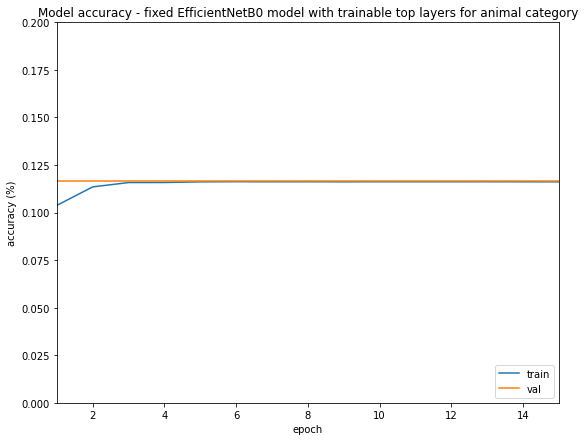

In [19]:
## Vizualise results with MatplotLib
plt.rcParams["figure.figsize"] = (9,7)
axes = plt.gca()
axes.set_xlim([1,15])
axes.set_ylim([0.0,0.2])
epochs = range(1, len(animal_category_fixed_training_res["loss"])+1)


plt.plot(epochs, animal_category_fixed_training_res['categorical_accuracy'])
plt.plot(epochs, animal_category_fixed_training_res['val_categorical_accuracy'])

plt.title("Model accuracy - fixed EfficientNetB0 model with trainable top layers for animal category")
plt.ylabel("accuracy (%)")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="lower right")

plt.show()